In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from readGCMs import read_var_mod
import calendar
from global_land_mask import globe
import glob

In [96]:
modname = ['CESM2','CNRM-CM6-1', 'CanESM5','CESM2-WACCM','E3SM-1-0',
           'HadGEM3-GC31-LL','IPSL-CM6A-LR','NorESM2-LM', 'SAM0-UNICON',
           'ACCESS-CM2','ACCESS-ESM1-5','CNRM-ESM2-1','EC-Earth3',
           'EC-Earth3-Veg','FGOALS-f3-L','GISS-E2-1-G-CC','HadGEM3-GC31-MM',
           'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0','NorCPM1',
           'UKESM1-0-LL']
varname = ['sfcWind', 'tas'] #'sfcWind', 'hfss', 'hfls', 'tas', 'ps', 'psl',
pvarname= ['ta']
conname = ['NCAR', 'CNRM-CERFACS','CCCma', 'NCAR', 'E3SM-Project', 'MOHC', 
           'IPSL', 'NCC', 'SNU','CSIRO-ARCCSS','CSIRO','CNRM-CERFACS',
           'EC-Earth-Consortium','EC-Earth-Consortium','CAS','NASA-GISS','MOHC'
           ,'INM','INM','MPI-M','MRI','NCC','MOHC'] 
ensname = ['r11i1p1f1', 'r1i1p1f2', 'r10i1p1f1', 'r1i1p1f1', 'r1i1p1f1', 
           'r1i1p1f3', 'r10i1p1f1', 'r1i1p1f1', 'r1i1p1f1','r1i1p1f1',
           'r10i1p1f1','r1i1p1f2','r101i1p1f1','r10i1p1f1','r1i1p1f1',
           'r1i1p1f1','r1i1p1f3','r1i1p1f1','r10i1p1f1','r10i1p1f1','r10i1p1f1',
           'r10i1p1f1','r10i1p1f2']
ggname  = ['gn', 'gr','gn', 'gn', 'gr', 'gn', 'gr', 'gn', 'gn','gn', 'gn', 'gr',
           'gr', 'gr', 'gr', 'gn', 'gn', 'gr1', 'gr1', 'gn', 'gr', 'gn', 'gn']


In [97]:
l = 1

In [98]:
try:
    for j in range(l,l+1):
        for i in varname: 
            locals()[i+'_'+str(j+1)] = read_var_mod(modn=modname[j], consort=conname[j], varnm=i, cmip='cmip6', exper='historical', ensmem=ensname[j], typevar='Amon', gg=ggname[j], read_p=False, time1=[2010, 1, 20], time2=[2012, 12, 21])

        for k in pvarname: 
            locals()[k+'_'+str(j+1)] = read_var_mod(modn=modname[j], consort=conname[j], varnm=k, cmip='cmip6', exper='historical', ensmem=ensname[j], typevar='Amon', gg=ggname[j], read_p=True, time1=[2010, 1, 20], time2=[2012, 12, 21])

except IndexError:
    print(str(j+1)+' not available')
            
            

In [99]:
try:
    for i in range(l,l+1):
        locals()['lat'+str(i+1)] = locals()['sfcWind_'+str(i+1)][2]
        locals()['lon'+str(i+1)] = locals()['sfcWind_'+str(i+1)][3]
        locals()['time'+str(i+1)] = locals()['sfcWind_'+str(i+1)][4]

        for j in varname:
            locals()[j+str(i+1)] = locals()[j+'_'+str(i+1)][0]

        for k in pvarname:
            locals()[k+str(i+1)] = locals()[k+'_'+str(i+1)][0]
            locals()['lev'+str(i+1)] = locals()['ta_'+str(i+1)][1]

except KeyError:
    print(str(i+1)+' not available')

In [5]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K
con= Rd/Cp

In [101]:
theta_850 = ta1[:,1,:,:]*(100/85)**con

In [102]:
M = tas1 - theta_850

In [103]:
x_lat = lat1
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (30)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]    

x_lon = lon1
# lon_ind1 = np.where(x_lon == x_lon.flat[np.abs(x_lon - (-180)).argmin()])[0]
# lon_ind2 = np.where(x_lon == x_lon.flat[np.abs(x_lon - (180)).argmin()])[0]

x_sfcWind = sfcWind1
m_sfcWind = x_sfcWind[0,lat_ind1[0]:lat_ind2[0],:]

x_M = M
m_M = x_M[0,lat_ind1[0]:lat_ind2[0],:]

In [104]:
cao = np.array(m_M)
sw  = np.array(m_sfcWind)

## wind vs M

In [105]:
gcm_cao = cao.reshape(-1)
gcm_sw  = sw.reshape(-1)

In [106]:

gcm_sw = gcm_sw[gcm_cao>(-30)]
gcm_cao = gcm_cao[gcm_cao>(-30)]

In [107]:
from scipy import stats
from skmisc.loess import loess

bin_means, bin_edges, binnumber = stats.binned_statistic(gcm_cao, gcm_sw, 'mean', bins=200)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

gcm_bin_means = bin_means[~np.isnan(bin_means)]
gcm_bin_centers = bin_centers[~np.isnan(bin_means)]

x = np.array(gcm_bin_centers)
y = np.array(gcm_bin_means)
ind = np.argsort(x)
xx = np.sort(x)
yy = y[ind]

gcml = loess(xx,yy)
gcml.fit()
gcmpred = gcml.predict(xx, stderror=True)
gcmconf = gcmpred.confidence()

gcmloess = gcmpred.values
gcmll = gcmconf.lower
gcmul = gcmconf.upper
gcmxx = xx

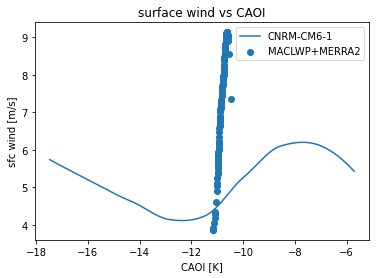

In [108]:
plt.plot(gcmxx,gcmloess,label=modname[l])
plt.scatter(macxx, macloess, label = 'MACLWP+MERRA2')
plt.title('surface wind vs CAOI')
plt.xlabel('CAOI [K]')
plt.ylabel('sfc wind [m/s]')
plt.legend()

In [69]:
import glob
merralist = np.sort(glob.glob('../data_merra/lat_30_70/un/MERRA2_300.inst3_3d_asm_Np.20100130.SUB.nc'))
# maclist = np.sort(glob.glob('../MACLWP_dailymean/take/wind1deg*.nc4'))

In [70]:
mac_wind  = []
mac_theta = []


for i in range(len(merralist)): #len(maclist)
    d_path = merralist[i]
    data   = xr.open_dataset(d_path)
    mlat = data.variables['lat'][:]
    mlon = data.variables['lon'][:]
    mlev = data.variables['lev'][:]
    mU   = data.variables['U'][:]
    mV   = data.variables['V'][:]
    mT   = data.variables['T'][:]
    
    # ddpath = maclist[i]
    # ddata   = xr.open_dataset(ddpath)
    # sfcwind= ddata.variables['sfcwind'][:]
    # slat = ddata.variables['lat'][:]
    # slon = ddata.variables['lon'][:]
    
    
    
    if i==0:
        maskm = np.ones((len(mlat),len(mlon)))

        for a in range(len(mlat)):
            for b in range(len(mlon)):
                if globe.is_land(mlat[a], mlon[b])==True:
                    maskm[a,b] = 0
    
    mw     = np.sqrt(np.add(mU[0,0,:,:]**2, mV[0,0,:,:]**2))
    mtheta = np.subtract(mT[0,0,:,:], np.multiply(mT[0,1,:,:], (100/85)**(Rd/Cp)))
    
    mmw    = np.array(np.multiply(maskm,mw)).reshape(-1)
    mmtheta= np.array(np.multiply(maskm,mtheta)).reshape(-1)
    
    mac_wind.extend(mmw)
    mac_theta.extend(mmtheta)
    

In [71]:
mac_wind  = np.array(mac_wind)
mac_theta = np.array(mac_theta)

In [72]:
mac_theta_nan = mac_theta[~np.isnan(mac_theta)]
mac_wind_nan = mac_wind[~np.isnan(mac_theta)]

In [74]:
from scipy import stats
from skmisc.loess import loess

bin_means, bin_edges, binnumber = stats.binned_statistic(mac_theta_nan, mac_wind_nan, 'mean', bins=200)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

mac_bin_means = bin_means[~np.isnan(bin_means)]
mac_bin_centers = bin_centers[~np.isnan(bin_means)]

x = np.array(mac_bin_centers)
y = np.array(mac_bin_means)
ind = np.argsort(x)
xx = np.sort(x)
yy = y[ind]

macl = loess(xx,yy)
macl.fit()
macpred = macl.predict(xx, stderror=True)
macconf = macpred.confidence()

macloess = macpred.values
macll = macconf.lower
macul = macconf.upper
macxx = xx

    

### west of scotland contour

In [ ]:
fig = plt.figure(figsize=(10,10))
scatter = plt.pcolormesh(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]],sw)
f = plt.contour(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]], cao,
                5,colors='white',levels=[0,4,8,12],linestyles='-')
g = plt.contour(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]], cao,
                5,colors='white',levels=[-12,-8,-4],linestyles='--')
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Surface wind speed (m/s)')
plt.clabel(f, inline=True, fontsize=10)
plt.clabel(g, inline=True, fontsize=10)
plt.title('U10[m/s] 20100120-20100131\nfor '+modname[l])
# plt.xticks(np.arange(-16, 0, step=2))
# plt.yticks(np.arange(55, 63, step=1))
plt.savefig('/glade/u/home/geethma/link/GCMres/pU10'+modname[l]+'.png')

# DYAMOND

In [3]:
d_path = '/glade/u/home/geethma/link/ifs_oper_T1279_2020012000.nc'
data =xr.open_dataset(d_path)
lon  = data.variables['lon'][:]  #(lon: 2560)
lat  = data.variables['lat'][:]  #(lat: 1280)
time = data.variables['time'][:] #1
lev  = data.variables['lev'][:]
t    = data.variables['t'][:]
u    = data.variables['u'][:]
v    = data.variables['v'][:]
sst  = data.variables['sst'][:]
hyam = data.variables['hyam'][:]

In [6]:
thetaD = np.multiply(t[:,110,:,:],((100/85)**con))
MD = np.subtract(sst,thetaD)

In [7]:
x_latD = np.array(lat)
lat_ind1 = np.where(x_latD == x_latD.flat[np.abs(x_latD - (63)).argmin()])[0]
lat_ind2 = np.where(x_latD == x_latD.flat[np.abs(x_latD - (55)).argmin()])[0]    

x_lonD = np.array(lon-180)
lon_ind1 = np.where(x_lonD == x_lonD.flat[np.abs(x_lonD - (-16)).argmin()])[0]
lon_ind2 = np.where(x_lonD == x_lonD.flat[np.abs(x_lonD - (-1)).argmin()])[0]

x_sfcWindD = np.sqrt(u[:,110,:,:]**2 + v[:,110,:,:]**2)
m_sfcWindD = x_sfcWindD[:,lat_ind1[0]:lat_ind2[0],lon_ind1[0]:lon_ind2[0]]

m_MD = MD[:,lat_ind1[0]:lat_ind2[0],lon_ind1[0]:lon_ind2[0]]

In [16]:
lon[1]-lon[0]

<xarray.Variable ()>
array(0.140625)

In [14]:
lon

<xarray.IndexVariable 'lon' (lon: 2560)>
array([0.000000e+00, 1.406250e-01, 2.812500e-01, ..., 3.595781e+02,
       3.597188e+02, 3.598594e+02])
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [8]:
caoD = np.mean(m_MD,axis=0)
swD  = np.mean(m_sfcWindD,axis=0)

<ipython-input-9-e7d0570a1464>:6: UserWarning: No contour levels were found within the data range.
  g = plt.contour(x_lonD[lon_ind1[0]:lon_ind2[0]], x_latD[lat_ind1[0]:lat_ind2[0]], caoD,


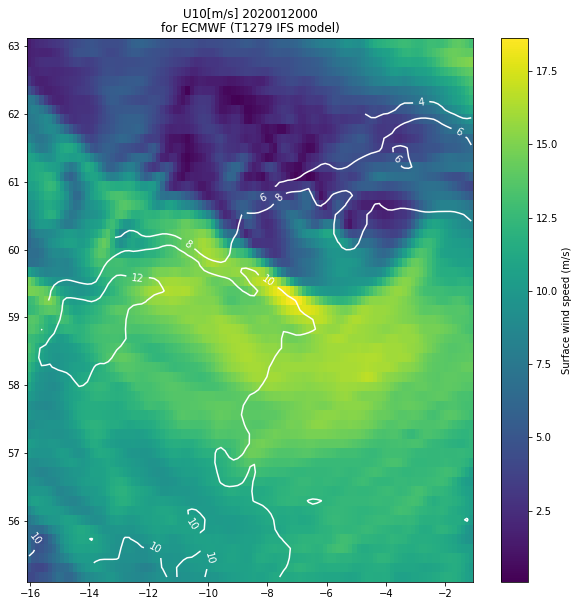

In [9]:
from matplotlib import cm
fig = plt.figure(figsize=(10,10))
scatter = plt.pcolormesh(x_lonD[lon_ind1[0]:lon_ind2[0]], x_latD[lat_ind1[0]:lat_ind2[0]],swD)
f = plt.contour(x_lonD[lon_ind1[0]:lon_ind2[0]], x_latD[lat_ind1[0]:lat_ind2[0]], caoD,
                5,colors='white',levels=[0,2,4,6,8,10,12],linestyles='-')
g = plt.contour(x_lonD[lon_ind1[0]:lon_ind2[0]], x_latD[lat_ind1[0]:lat_ind2[0]], caoD,
                5,colors='white',levels=[-12,-8,-4],linestyles='--')
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Surface wind speed (m/s)')
plt.clabel(f, inline=True, fontsize=10)
plt.clabel(g, inline=True, fontsize=10)
plt.title('U10[m/s] 2020012000\nfor ECMWF (T1279 IFS model)')
# plt.xticks(np.arange(-16, 0, step=2))
# plt.yticks(np.arange(55, 63, step=1))
plt.savefig('/glade/u/home/geethma/link/GCMres/U10_DYAMOND.png')

## whole globe CESM2

In [252]:
thetaD = np.multiply(t,((100/85)**con))
MD = np.subtract(sst,thetaD)

In [248]:
x_sfcWindD = np.sqrt(u**2 + v**2)

In [254]:
MDD = np.mean(np.mean(MD,axis=0),axis=2)

In [258]:
m_sfcWindD = np.mean(np.mean(x_sfcWindD,axis=0),axis=0)
np.shape(m_sfcWindD)

(1280, 2560)

Text(0.5, 1.0, 'U10[m/s] 2020012000\nfor DYAMOND')

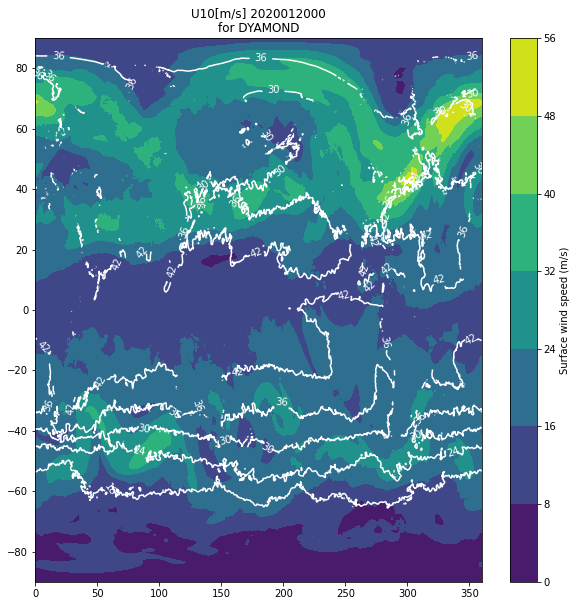

In [261]:
fig = plt.figure(figsize=(10,10))
scatter = plt.contourf(lon, lat,m_sfcWindD)
f = plt.contour(lon, lat, MDD,
                5,colors='white')
# g = plt.contour(lon, lat, MDD,
#                 5,colors='white',levels=[-12,-8,-4],linestyles='--')
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Surface wind speed (m/s)')
plt.clabel(f, inline=True, fontsize=10)
plt.clabel(g, inline=True, fontsize=10)
plt.title('U10[m/s] 2020012000\nfor DYAMOND')

<a list of 45 text.Text objects>

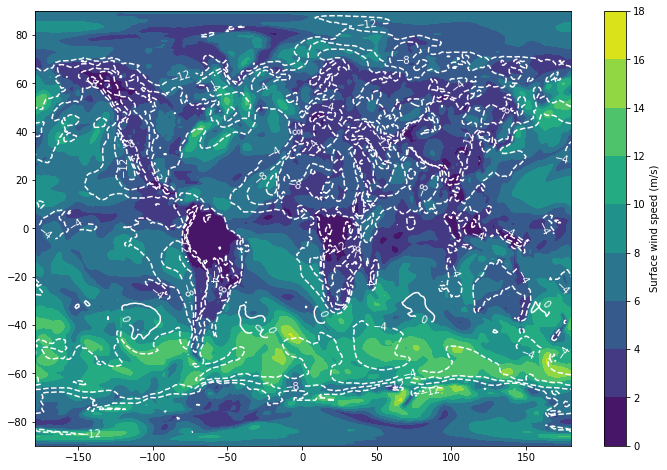

In [17]:
fig = plt.figure(figsize=(12,8))
scatter = plt.contourf(lon1, lat1,sfcWind1)
# f = plt.contour(lon1, lat1,M,5,colors='white',levels=[0,4,8,12],linestyles='-')
# g = plt.contour(lon1, lat1,M,5,colors='white',levels=[-12,-8,-4],linestyles='--')
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Surface wind speed (m/s)')
plt.clabel(f, inline=True, fontsize=10)
plt.clabel(g, inline=True, fontsize=10)

# MACLWP

In [56]:
d_path = '../MERRA2_300.inst3_3d_asm_Np.20100130.SUB.nc'
data   = xr.open_dataset(d_path)

mlat = data.variables['lat'][:]
mlon = data.variables['lon'][:]
mlev = data.variables['lev'][:]
mU   = data.variables['U'][:]
mV   = data.variables['V'][:]
mT   = data.variables['T'][:]

mw     = np.sqrt(np.add(mU[0,0,:,:]**2, mV[0,0,:,:]**2))
mtheta = np.subtract(mT[0,0,:,:], np.multiply(mT[0,8,:,:], (10/8)**(Rd/Cp)))

In [58]:
mw_nan     = np.array(mw[:, ~np.isnan(mw).any(axis=0)]).reshape(-1)
mtheta_nan = np.array(mtheta[:, ~np.isnan(mw).any(axis=0)]).reshape(-1)

<ipython-input-62-7885f8ce0edf>:4: UserWarning: No contour levels were found within the data range.
  f = plt.contour(mlon, mlat, mtheta,


Text(0.5, 1.0, 'U10[m/s] 2010013012Z\nfor MACLWP')

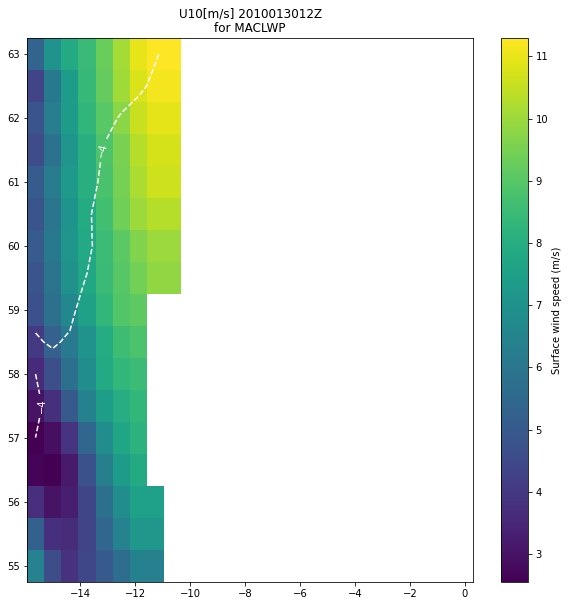

In [62]:
from matplotlib import cm
fig = plt.figure(figsize=(10,10))
scatter = plt.pcolormesh(mlon, mlat,mw)
f = plt.contour(mlon, mlat, mtheta,
                5,colors='white',levels=[0,2,4,6,8,10,12],linestyles='-')
g = plt.contour(mlon, mlat, mtheta,
                5,colors='white',levels=[-12,-8,-4],linestyles='--')
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Surface wind speed (m/s)')
plt.clabel(f, inline=True, fontsize=10)
plt.clabel(g, inline=True, fontsize=10)
plt.title('U10[m/s] 2010013012Z\nfor MACLWP')